In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
import cvxpy as cvx
import mosek

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_kernels
from random import sample


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from group import compute_group_coverages, compute_split_coverages 
from group import compute_group_qr_coverages, compute_cqr_coverages
from Synthetic_data_generation import get_groups, generate_group_synthetic_data, generate_cqr_data
from rkhs import compute_shifted_coverage, compute_qr_coverages
from rkhs import compute_adaptive_threshold, setup_full_cvx_dual, runCV


In [8]:
attrib = pd.read_csv('data/CandCData/attributes.csv', delim_whitespace = True)
data = pd.read_csv('data/CandCData/communities.data', names = attrib['attributes'])
data = data.drop(columns=['state','county',
                          'community','communityname',
                          'fold'], axis=1)
data = data.replace('?', np.nan)
data = data.dropna(axis=1)
print(data.shape)
data.head()

(1994, 100)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [9]:
features = ['population','racepctblack','racePctWhite','racePctAsian',
            'racePctHisp','agePct12t21','agePct16t24','agePct65up','medIncome','PctUnemployed','ViolentCrimesPerPop']
data_sub = data[features]

print(data_sub.shape)
data_sub.head()


(1994, 11)


,population,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct16t24,agePct65up,medIncome,PctUnemployed,ViolentCrimesPerPop
0,0.19,0.02,0.90,0.12,0.17,0.34,0.29,0.32,0.37,0.27,0.20
1,0.00,0.12,0.74,0.45,0.07,0.26,0.35,0.27,0.31,0.27,0.67
2,0.00,0.49,0.56,0.17,0.04,0.39,0.28,0.32,0.30,0.36,0.43
3,0.04,1.00,0.08,0.12,0.10,0.51,0.34,0.21,0.58,0.33,0.12
4,0.01,0.02,0.95,0.09,0.05,0.38,0.23,0.36,0.50,0.12,0.03


In [10]:
def compute_coverage_at_shift(x_test,scores_test,coverages,x_shift,gamma, eps = 0.0001):
    g = pairwise_kernels(
                X=pd.Series.to_numpy(x_shift).reshape(1, -1),
                Y=x_test,
                metric="rbf",
                gamma=gamma
            )[0,:]
    return np.average(coverages, weights=g)

def compute_estimated_shifted_coverage( 
        scores_calib : np.ndarray, 
        x_calib : np.ndarray, 
        shift_loc : np.ndarray, 
        kernel : str, 
        alpha : float, 
        radius : float,
        gamma : float,
        z_calib : np.ndarray,
):
    prob_calib = setup_full_cvx_dual(
        x_calib,
        scores_calib,
        kernel=kernel,
        gamma=gamma,
        alpha=alpha,
        z_calib=z_calib
    )
    prob_calib.param_dict['radius'].value = np.asarray([[radius]])
    prob_calib.solve(
        solver='MOSEK', 
        verbose=False, 
        mosek_params={mosek.iparam.intpnt_solve_form: mosek.solveform.dual}
    )

    g = pairwise_kernels(
        X=shift_loc.reshape(1,-1),
        Y=x_calib,
        metric=kernel,
        gamma=gamma
    )

    inner_product = g @ prob_calib.var_dict['weights'].value
    g_sum = np.mean((g))
    
    return alpha - (1 / radius) * (inner_product / g_sum)


def one_LQR_exp(X,Y,n_test,n_calib,alpha,gamma,protectedFeatures,featuresToPlot,cutoffs,
                                    min_radius,max_radius,num_radii,k,radius=None,eps=0.0001):
    held_out_points = sample(range(0,len(Y)),n_calib + n_test)
    test_points = held_out_points[0:n_test]
    calib_points = held_out_points[n_test:]
    
    X_test = pd.DataFrame.to_numpy(X.iloc[test_points,:])
    Y_test = pd.Series.to_numpy(Y.iloc[test_points])
    X_calib = pd.DataFrame.to_numpy(X.iloc[calib_points,:])
    Y_calib = pd.Series.to_numpy(Y.iloc[calib_points])
    X_train = pd.DataFrame.to_numpy(X.drop(held_out_points,axis = 0))
    Y_train = pd.Series.to_numpy(Y.drop(held_out_points,axis = 0))
    X_train_qr = pd.DataFrame.to_numpy(X.drop(test_points,axis=0))
    Y_train_qr = pd.Series.to_numpy(Y.drop(test_points,axis=0))
    
    reg = LinearRegression().fit(X_train,Y_train)
    scores_calib = np.abs(reg.predict(X_calib) - Y_calib)
    scores_test =  np.abs(reg.predict(X_test) - Y_test)
    q = np.quantile(scores_calib, [alpha * (1 + 1/n_calib)])
    baseline_coverages = scores_test <= q
    baseline__marginal_coverage = np.mean(baseline_coverages)
    
    z_calib = pd.DataFrame.to_numpy(X.drop(test_points,axis=0)[protectedFeatures])
    z_test = pd.DataFrame.to_numpy(X.iloc[test_points,:][protectedFeatures])
    
    if radius is None:
        allLosses, radii = runCV(X_train_qr,Y_train_qr,'rbf',gamma,alpha,k,
                                 min_radius,max_radius, num_radii, z_calib)
        selectedRadius = radii[np.argmin(allLosses)]
        #print(allLosses)
        print(selectedRadius)
    else:
        selectedRadius = radius
    
    _, adaptive__marginal_coverage, adaptive_thresholds = compute_shifted_coverage(
        Y_test,
        Y_train_qr,
        X_train_qr,
        X_test,
        None,
        kernel="rbf",
        alpha=alpha,
        radius=selectedRadius,
        gamma=gamma,
        z_calib=z_calib,
        z_test=z_test,
        exact=True,
        eps=eps
    )
    adaptive_coverages = Y_test <= adaptive_thresholds
    
        
    protected_results_df = pd.DataFrame({'Coverage' : [adaptive__marginal_coverage, baseline__marginal_coverage],
                             'type' : ['Robust','Split'],'Shift Type' : ['Marginal','Marginal']})
    
    for feature in protectedFeatures + featuresToPlot:
        if feature != 'intercept':
            adaptive_protected_cov = np.mean(adaptive_coverages[X.iloc[test_points,:][feature]>cutoffs[feature]])
            baseline_protected_cov = np.mean(baseline_coverages[X.iloc[test_points,:][feature]>cutoffs[feature]])

            shift_type = feature + ' > ' + str(cutoffs[feature])
            protected_df = pd.DataFrame({'Coverage' : [adaptive_protected_cov, baseline_protected_cov],
                             'type' : ['Robust','Split'],'Shift Type' : [shift_type,shift_type]})
            
            protected_results_df = pd.concat([protected_results_df,protected_df])
    
    shift_results_df = pd.DataFrame()
    for shift in shift_locs:
        adaptive_shifted_cov = compute_coverage_at_shift(X_test,Y_test,adaptive_coverages,
                                                         X.iloc[shift,:],gamma, eps = 0.0001)
        
        
        adaptive_estimated_cov = compute_estimated_shifted_coverage(Y_train_qr, X_train_qr,
                                                                    pd.Series.to_numpy(X.iloc[shift,:]), "rbf", 
                                                                    alpha, selectedRadius, gamma, z_calib
                                )[0]
        shift_df = pd.DataFrame({'Coverage' : [adaptive_shifted_cov, adaptive_estimated_cov],
                             'type' : ['Empirical','Estimated'],'Shift Type' : [shift,shift]})
            
        shift_results_df = pd.concat([shift_results_df,shift_df])
        
    return protected_results_df, shift_results_df


X = data_sub.drop(['ViolentCrimesPerPop'],axis=1)
X['intercept'] = np.ones(len(X))
Y = data_sub['ViolentCrimesPerPop']
n_test = 200
n_train = 300
n_calib = 500
n = n_train + n_calib + n_test
alpha = 0.9
gamma = 4
#radius = 10
protectedFeatures = ['racepctblack','racePctWhite','racePctAsian','racePctHisp','intercept']
featuresToPlot = ['medIncome','agePct65up']
shift_locs = [37,689]
n_trials = 50
min_radius = 0.01
max_radius = 20
num_radii = 20
k = 5

cutoffs = {}
for col in protectedFeatures + featuresToPlot:
    cutoffs[col] = np.quantile(X[col],0.75)
print(cutoffs)

protected_df = pd.DataFrame()
shift_df = pd.DataFrame()
for i in range(n_trials):
    append_df_protected, append_df_shift = one_LQR_exp(X.iloc[0:n,:],Y[0:n],n_test,n_calib,alpha,gamma,
                                                       protectedFeatures,featuresToPlot,cutoffs,min_radius, max_radius,
                                                       num_radii, k)
    append_df_protected['trial'] = i
    append_df_shift['trial'] = i
    protected_df = pd.concat([protected_df,append_df_protected])
    shift_df = pd.concat([shift_df,append_df_shift])


{'racepctblack': 0.23, 'racePctWhite': 0.94, 'racePctAsian': 0.17, 'racePctHisp': 0.16, 'intercept': 1.0, 'medIncome': 0.49, 'agePct65up': 0.53}


100%|███████████████████████████████████████████| 20/20 [01:03<00:00,  3.15s/it]


1.0621052631578947


100%|███████████████████████████████████████████| 20/20 [00:35<00:00,  1.76s/it]


3.1663157894736838


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


0.01


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


2.114210526315789


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.68s/it]


3.1663157894736838


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.68s/it]


12.635263157894736


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.70s/it]


7.374736842105262


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


0.01


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.69s/it]


1.0621052631578947


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.66s/it]


2.114210526315789


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


2.114210526315789


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


2.114210526315789


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.70s/it]


1.0621052631578947


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.66s/it]


1.0621052631578947


100%|███████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


7.374736842105262


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.70s/it]


0.01


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


5.270526315789473


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


0.01


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.68s/it]


16.843684210526316


100%|███████████████████████████████████████████| 20/20 [00:32<00:00,  1.65s/it]


3.1663157894736838


100%|███████████████████████████████████████████| 20/20 [00:32<00:00,  1.65s/it]


0.01


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.68s/it]


1.0621052631578947


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.68s/it]


0.01


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.71s/it]


3.1663157894736838


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.69s/it]


0.01


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.71s/it]


3.1663157894736838


100%|███████████████████████████████████████████| 20/20 [00:32<00:00,  1.65s/it]


5.270526315789473


100%|███████████████████████████████████████████| 20/20 [00:35<00:00,  1.75s/it]


1.0621052631578947


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.68s/it]


1.0621052631578947


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


5.270526315789473


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


3.1663157894736838


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.74s/it]


1.0621052631578947


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


14.739473684210525


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.73s/it]


11.583157894736841


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.70s/it]


1.0621052631578947


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.70s/it]


0.01


100%|███████████████████████████████████████████| 20/20 [00:36<00:00,  1.81s/it]


3.1663157894736838


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


2.114210526315789


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.69s/it]


10.531052631578946


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.70s/it]


0.01


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.70s/it]


4.218421052631578


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.70s/it]


1.0621052631578947


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


5.270526315789473


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


1.0621052631578947


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.68s/it]


5.270526315789473


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.70s/it]


6.322631578947368


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.66s/it]


5.270526315789473


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


0.01


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.68s/it]


0.01


100%|███████████████████████████████████████████| 20/20 [00:33<00:00,  1.68s/it]


5.270526315789473


100%|█████████████████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


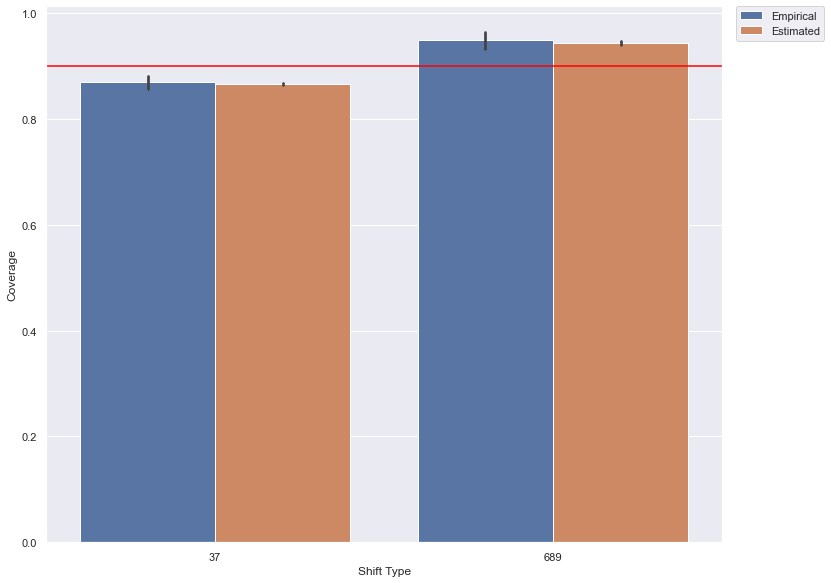

In [30]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

fig = sns.barplot(shift_df,x='Shift Type',y='Coverage',hue='type')
fig.axhline(alpha, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig('figures/CandCRbfShiftsEmpVsEst.png')

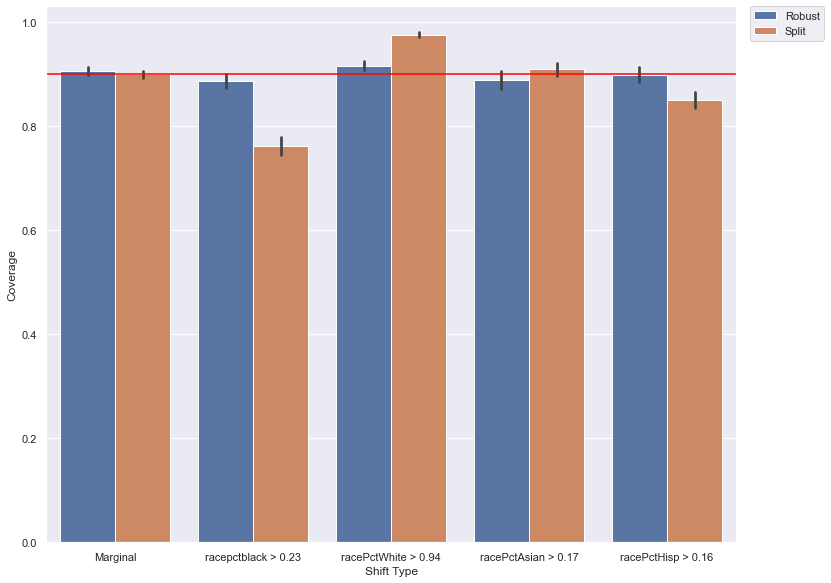

In [27]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

protected_df_sub = protected_df[np.logical_and(protected_df['Shift Type'] != 'medIncome > 0.49', 
                                protected_df['Shift Type'] != 'agePct65up > 0.53')]

fig = sns.barplot(protected_df_sub,x='Shift Type',y='Coverage',hue='type')
fig.axhline(alpha, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig('figures/CandCCuttofShiftCoverages.png')

In [15]:
alpha = 0.9
gamma = 4
radius = 3
n_to_use = n_train + n_calib

Z = pd.DataFrame.to_numpy(X[protectedFeatures])
Xnp = pd.DataFrame.to_numpy(X)
Ynp = pd.Series.to_numpy(Y)

prob = setup_full_cvx_dual(Xnp[0:n_to_use,:], Ynp[0:n_to_use], 'rbf', gamma, alpha, Z[0:n_to_use,:])
prob.param_dict['radius'].value = np.array([[radius]])
prob.solve(
                solver='MOSEK', 
                verbose=False, 
                mosek_params={mosek.iparam.intpnt_solve_form: mosek.solveform.dual}
            )
c0 = prob.constraints[-1].dual_value
weights = prob.var_dict['weights'].value
K = pairwise_kernels(
    X = Xnp[0:n_to_use,:],
    metric='rbf',
    gamma=gamma
)
cov_gaps = alpha-(1/radius) * K @ weights / (K @ np.ones(n_to_use) / n_to_use)


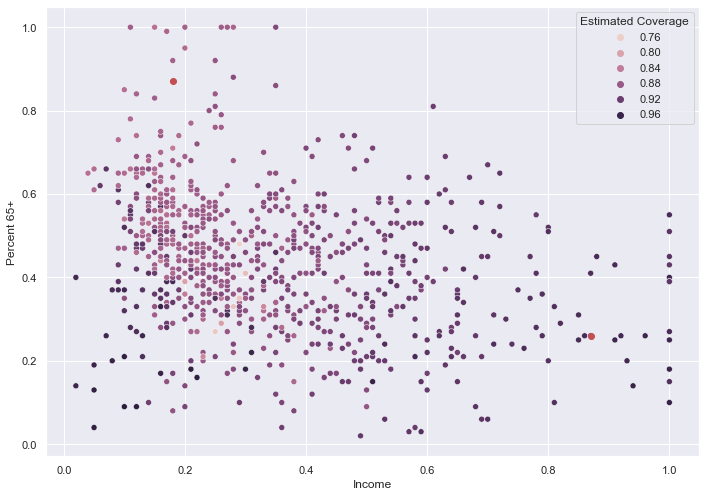

In [31]:
#['population','racepctblack','racePctWhite','racePctAsian',
#            'racePctHisp','agePct12t21','agePct16t24','agePct65up','medIncome','PctUnemployed','ViolentCrimesPerPop']
scatterplot_df = pd.DataFrame({'Income' : X['medIncome'][0:n_to_use][cov_gaps>0.75],
                               'Percent 65+': X['agePct65up'][0:n_to_use][cov_gaps>0.75],
                                                              'Estimated Coverage' : cov_gaps[cov_gaps>0.75]})

sns.scatterplot(scatterplot_df,x='Income',y='Percent 65+',hue='Estimated Coverage')
plt.scatter(x=X['medIncome'][37], y=X['agePct65up'][37], color='r')
plt.scatter(x=X['medIncome'][689], y=X['agePct65up'][689], color='r')
plt.savefig('figures/CandCCoverageScatterPlot.png')
plt.show()
